**Importing Libraries**

In [1]:
pip install tensorflow

In [2]:
import tensorflow as tf

import pandas as pd
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
import re
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer

import matplotlib.pyplot as plt
from nltk import ngrams
from nltk.corpus import stopwords
from collections import Counter
import numpy as np
from nltk.tokenize import word_tokenize

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Import libraries for building the LSTM model
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, GlobalMaxPooling1D, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Import libraries for evaluation and visualization
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score

import seaborn as sns


nltk.download('punkt')
import json
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import precision_recall_curve, average_precision_score
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense, Dropout, Input
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


**Loading data**

In [3]:
# Loading the dataset
(train_data, test_data), info = tfds.load('ag_news_subset', split=['train', 'test'], with_info=True, as_supervised=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/120000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/ag_news_subset/incomplete.ALBAN3_1.0.0/ag_news_subset-train.tfrecord*...: …

Generating test examples...:   0%|          | 0/7600 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/ag_news_subset/incomplete.ALBAN3_1.0.0/ag_news_subset-test.tfrecord*...:  …

Dataset ag_news_subset downloaded and prepared to /root/tensorflow_datasets/ag_news_subset/1.0.0. Subsequent calls will reuse this data.


Label 0: World\
Label 1: Sports\
Label 2: Business\
Label 3: Science/Technology

In [4]:
print("Training samples:", info.splits['train'].num_examples)
print("Testing samples:", info.splits['test'].num_examples)

Training samples: 120000
Testing samples: 7600


In [5]:
def display_samples(dataset, num_samples=5):
    for text, label in dataset.take(num_samples):
        print("Label:", label.numpy())
        print("Text:", text.numpy().decode('utf-8'))
        print("-" * 80)


print("Training Samples:")
display_samples(train_data)

print("\nTesting Samples:")
display_samples(test_data)


Training Samples:
Label: 3
Text: AMD #39;s new dual-core Opteron chip is designed mainly for corporate computing applications, including databases, Web services, and financial transactions.
--------------------------------------------------------------------------------
Label: 1
Text: Reuters - Major League Baseball\Monday announced a decision on the appeal filed by Chicago Cubs\pitcher Kerry Wood regarding a suspension stemming from an\incident earlier this season.
--------------------------------------------------------------------------------
Label: 2
Text: President Bush #39;s  quot;revenue-neutral quot; tax reform needs losers to balance its winners, and people claiming the federal deduction for state and local taxes may be in administration planners #39; sights, news reports say.
--------------------------------------------------------------------------------
Label: 3
Text: Britain will run out of leading scientists unless science education is improved, says Professor Colin Pilli

In [6]:


def dataset_to_dataframe(dataset):

    data = []

    for text, label in dataset:
        data.append({
            "Text": text.numpy().decode('utf-8'),
            "Label": label.numpy()
        })

    df = pd.DataFrame(data)
    return df


train_data_df = dataset_to_dataframe(train_data)
print("Training Dataset:")
print(train_data_df)


test_data_df = dataset_to_dataframe(test_data)
print("\nTesting Dataset:")
print(test_data_df)



Training Dataset:
                                                     Text  Label
0       AMD #39;s new dual-core Opteron chip is design...      3
1       Reuters - Major League Baseball\Monday announc...      1
2       President Bush #39;s  quot;revenue-neutral quo...      2
3       Britain will run out of leading scientists unl...      3
4       London, England (Sports Network) - England mid...      1
...                                                   ...    ...
119995  Ivan Ljubicic edged No. 7 seed Joachim Johanss...      1
119996  MANAMA: A \$1.3 billion (BD491 million) combin...      2
119997  And lo, the hawk begat the dove. At least that...      0
119998  West Palm Beach, FL (Sports Network) - Tom Leh...      1
119999  If the Federal Communications Commission has i...      2

[120000 rows x 2 columns]

Testing Dataset:
                                                   Text  Label
0      CHARLOTTE, N.C. (Sports Network) - Carolina P...      1
1      PRESENTACION, Philippine

In [7]:
pd.set_option('display.max_colwidth', None)


train_data_df.head(10)



,Text,Label
0,"AMD #39;s new dual-core Opteron chip is designed mainly for corporate computing applications, including databases, Web services, and financial transactions.",3
1,Reuters - Major League Baseball\Monday announced a decision on the appeal filed by Chicago Cubs\pitcher Kerry Wood regarding a suspension stemming from an\incident earlier this season.,1
2,"President Bush #39;s quot;revenue-neutral quot; tax reform needs losers to balance its winners, and people claiming the federal deduction for state and local taxes may be in administration planners #39; sights, news reports say.",2
3,"Britain will run out of leading scientists unless science education is improved, says Professor Colin Pillinger.",3
4,"London, England (Sports Network) - England midfielder Steven Gerrard injured his groin late in Thursday #39;s training session, but is hopeful he will be ready for Saturday #39;s World Cup qualifier against Austria.",1
5,TOKYO - Sony Corp. is banking on the \$3 billion deal to acquire Hollywood studio Metro-Goldwyn-Mayer Inc...,0
6,"Giant pandas may well prefer bamboo to laptops, but wireless technology is helping researchers in China in their efforts to protect the engandered animals living in the remote Wolong Nature Reserve.",3
7,"VILNIUS, Lithuania - Lithuania #39;s main parties formed an alliance to try to keep a Russian-born tycoon and his populist promises out of the government in Sunday #39;s second round of parliamentary elections in this Baltic country.",0
8,Witnesses in the trial of a US soldier charged with abusing prisoners at Abu Ghraib have told the court that the CIA sometimes directed abuse and orders were received from military command to toughen interrogations.,0
9,"Dan Olsen of Ponte Vedra Beach, Fla., shot a 7-under 65 Thursday to take a one-shot lead after two rounds of the PGA Tour qualifying tournament.",1


In [8]:
test_data_df.head(10)

,Text,Label
0,"CHARLOTTE, N.C. (Sports Network) - Carolina Panthers running back Stephen Davis will miss the remainder of the season after being placed on injured reserve Saturday.",1
1,"PRESENTACION, Philippines (Reuters) - Philippine communist rebels freed Wednesday two soldiers they had held as ""prisoners of war"" for more than five months, saying they wanted to rebuild confidence in peace talks with the government.",0
2,"SAN FRANCISCO, CA - November 30, 2004 -Ubisoft, one of the world #39;s largest video game publishers, today announced its plans to launch the next installment in the Tom Clancy #39;s Rainbow SixR franchise for the Sony PlayStationR2 computer entertainment system",3
3,DANIEL VETTORI spun New Zealand to the brink of a crushing victory over Bangladesh in the second and final Test at the MA Aziz Stadium in Chittagong today.,1
4,"AFP - Georgian and South Ossetian forces overnight accused each other of trying to storm the other side's positions in Georgia's breakaway region of South Ossetia, as four Georgian soldiers were reported to be wounded.",0
5,Hewlett-Packard has signed a deal to sell network adapters from start-up S2io that the companies say can transfer data 10 times faster than today #39;s widespread standard.,3
6,Annika Sorenstam could only manage a level-par 72 on day three of the ADT Tour Championship in Florida but it was enough to maintain a one-stroke lead.,1
7,AP - Maria Sharapova withdrew from her semifinal at the Advanta Championships on Saturday with a strained right shoulder.,1
8,"The governments of Serbia and the Bosnian Serb enclave of Bosnia-Herzegovina have failed to bring war crimes suspects to the United Nations tribunal, Chief Prosecutor Carla Del Ponte told the Security Council.",0
9,"The nation #39;s two largest automakers on Wednesday reported weak November sales, but both expressed confidence that new products would help them pick up momentum.",2


**checking for null values**

In [9]:
train_data_df.isna().sum()

,0
Text,0
Label,0


In [10]:
test_data_df.isna().sum()

,0
Text,0
Label,0


**Checking for duplicates**

In [11]:
duplicates = test_data_df[test_data_df.duplicated()]
print("Duplicate Rows:")
print(duplicates)

num_duplicates = test_data_df.duplicated().sum()
print(f"Number of duplicate rows: {num_duplicates}")

Duplicate Rows:
                                                                                                                                                                                                                                                  Text  \
5138                                                                               Most IT Managers won #39;t question the importance of security, but this priority has been sliding between the third and fourth most important focus for companies.   
5515          ST. LOUIS (Reuters) - Pedro Martinez pitched seven shutout  innings and Manny Ramirez hit a home run as the Boston Red Sox  beat the St. Louis Cardinals 4-1 Tuesday, moving to the brink  of their first World Series title since 1918.   
5706                                    Sysco Corp., the country #39;s largest food service distributor, Monday said profit for its latest quarter rose 8 percent, as it increased sales and trimmed expenses despite the hurricanes in th

In [12]:
duplicates = train_data_df[train_data_df.duplicated()]
print("Duplicate Rows:")
print(duplicates)

num_duplicates = train_data_df.duplicated().sum()
print(f"Number of duplicate rows: {num_duplicates}")

Duplicate Rows:
                                                                                                                                                                                                                                       Text  \
4327                                         Deutsche Bank AG and Thomas Weisel Partners LLC will pay a total of \$100 million to settle allegations they published misleading stock research to win investment-banking business, becoming    
5543    AP - At first glance, Les Seules might look like an all-girl rock band  #151; complete with sassy attitudes and fawning male groupies  #151; but the Swedish septuplet doesn't play instruments. They play competitive video games.   
5575                                                     Reuters - High-definition television can\show the sweat beading on an athlete's brow, but the cost of\all the necessary electronic equipment can get a shopper's own\pulse racing.   
5939                        

In [13]:
train_data_df = train_data_df.drop_duplicates()

In [14]:
test_data_df = test_data_df.drop_duplicates()

**Converting to Lower Case**


In [15]:
train_data_df['Text']=train_data_df['Text'].str.lower()
train_data_df.head(10)


,Text,Label
0,"amd #39;s new dual-core opteron chip is designed mainly for corporate computing applications, including databases, web services, and financial transactions.",3
1,reuters - major league baseball\monday announced a decision on the appeal filed by chicago cubs\pitcher kerry wood regarding a suspension stemming from an\incident earlier this season.,1
2,"president bush #39;s quot;revenue-neutral quot; tax reform needs losers to balance its winners, and people claiming the federal deduction for state and local taxes may be in administration planners #39; sights, news reports say.",2
3,"britain will run out of leading scientists unless science education is improved, says professor colin pillinger.",3
4,"london, england (sports network) - england midfielder steven gerrard injured his groin late in thursday #39;s training session, but is hopeful he will be ready for saturday #39;s world cup qualifier against austria.",1
5,tokyo - sony corp. is banking on the \$3 billion deal to acquire hollywood studio metro-goldwyn-mayer inc...,0
6,"giant pandas may well prefer bamboo to laptops, but wireless technology is helping researchers in china in their efforts to protect the engandered animals living in the remote wolong nature reserve.",3
7,"vilnius, lithuania - lithuania #39;s main parties formed an alliance to try to keep a russian-born tycoon and his populist promises out of the government in sunday #39;s second round of parliamentary elections in this baltic country.",0
8,witnesses in the trial of a us soldier charged with abusing prisoners at abu ghraib have told the court that the cia sometimes directed abuse and orders were received from military command to toughen interrogations.,0
9,"dan olsen of ponte vedra beach, fla., shot a 7-under 65 thursday to take a one-shot lead after two rounds of the pga tour qualifying tournament.",1


In [16]:
test_data_df['Text']=test_data_df['Text'].str.lower()
test_data_df.head(10)

,Text,Label
0,"charlotte, n.c. (sports network) - carolina panthers running back stephen davis will miss the remainder of the season after being placed on injured reserve saturday.",1
1,"presentacion, philippines (reuters) - philippine communist rebels freed wednesday two soldiers they had held as ""prisoners of war"" for more than five months, saying they wanted to rebuild confidence in peace talks with the government.",0
2,"san francisco, ca - november 30, 2004 -ubisoft, one of the world #39;s largest video game publishers, today announced its plans to launch the next installment in the tom clancy #39;s rainbow sixr franchise for the sony playstationr2 computer entertainment system",3
3,daniel vettori spun new zealand to the brink of a crushing victory over bangladesh in the second and final test at the ma aziz stadium in chittagong today.,1
4,"afp - georgian and south ossetian forces overnight accused each other of trying to storm the other side's positions in georgia's breakaway region of south ossetia, as four georgian soldiers were reported to be wounded.",0
5,hewlett-packard has signed a deal to sell network adapters from start-up s2io that the companies say can transfer data 10 times faster than today #39;s widespread standard.,3
6,annika sorenstam could only manage a level-par 72 on day three of the adt tour championship in florida but it was enough to maintain a one-stroke lead.,1
7,ap - maria sharapova withdrew from her semifinal at the advanta championships on saturday with a strained right shoulder.,1
8,"the governments of serbia and the bosnian serb enclave of bosnia-herzegovina have failed to bring war crimes suspects to the united nations tribunal, chief prosecutor carla del ponte told the security council.",0
9,"the nation #39;s two largest automakers on wednesday reported weak november sales, but both expressed confidence that new products would help them pick up momentum.",2


**Removing html tags**

In [17]:

def remove_html_tags(text):
    pattern = re.compile('<.*?>')
    return pattern.sub('', text)

In [18]:
train_data_df['Text']=train_data_df['Text'].apply(remove_html_tags)
train_data_df.head(10)

,Text,Label
0,"amd #39;s new dual-core opteron chip is designed mainly for corporate computing applications, including databases, web services, and financial transactions.",3
1,reuters - major league baseball\monday announced a decision on the appeal filed by chicago cubs\pitcher kerry wood regarding a suspension stemming from an\incident earlier this season.,1
2,"president bush #39;s quot;revenue-neutral quot; tax reform needs losers to balance its winners, and people claiming the federal deduction for state and local taxes may be in administration planners #39; sights, news reports say.",2
3,"britain will run out of leading scientists unless science education is improved, says professor colin pillinger.",3
4,"london, england (sports network) - england midfielder steven gerrard injured his groin late in thursday #39;s training session, but is hopeful he will be ready for saturday #39;s world cup qualifier against austria.",1
5,tokyo - sony corp. is banking on the \$3 billion deal to acquire hollywood studio metro-goldwyn-mayer inc...,0
6,"giant pandas may well prefer bamboo to laptops, but wireless technology is helping researchers in china in their efforts to protect the engandered animals living in the remote wolong nature reserve.",3
7,"vilnius, lithuania - lithuania #39;s main parties formed an alliance to try to keep a russian-born tycoon and his populist promises out of the government in sunday #39;s second round of parliamentary elections in this baltic country.",0
8,witnesses in the trial of a us soldier charged with abusing prisoners at abu ghraib have told the court that the cia sometimes directed abuse and orders were received from military command to toughen interrogations.,0
9,"dan olsen of ponte vedra beach, fla., shot a 7-under 65 thursday to take a one-shot lead after two rounds of the pga tour qualifying tournament.",1


In [19]:
test_data_df['Text']=test_data_df['Text'].apply(remove_html_tags)
test_data_df.head(10)

,Text,Label
0,"charlotte, n.c. (sports network) - carolina panthers running back stephen davis will miss the remainder of the season after being placed on injured reserve saturday.",1
1,"presentacion, philippines (reuters) - philippine communist rebels freed wednesday two soldiers they had held as ""prisoners of war"" for more than five months, saying they wanted to rebuild confidence in peace talks with the government.",0
2,"san francisco, ca - november 30, 2004 -ubisoft, one of the world #39;s largest video game publishers, today announced its plans to launch the next installment in the tom clancy #39;s rainbow sixr franchise for the sony playstationr2 computer entertainment system",3
3,daniel vettori spun new zealand to the brink of a crushing victory over bangladesh in the second and final test at the ma aziz stadium in chittagong today.,1
4,"afp - georgian and south ossetian forces overnight accused each other of trying to storm the other side's positions in georgia's breakaway region of south ossetia, as four georgian soldiers were reported to be wounded.",0
5,hewlett-packard has signed a deal to sell network adapters from start-up s2io that the companies say can transfer data 10 times faster than today #39;s widespread standard.,3
6,annika sorenstam could only manage a level-par 72 on day three of the adt tour championship in florida but it was enough to maintain a one-stroke lead.,1
7,ap - maria sharapova withdrew from her semifinal at the advanta championships on saturday with a strained right shoulder.,1
8,"the governments of serbia and the bosnian serb enclave of bosnia-herzegovina have failed to bring war crimes suspects to the united nations tribunal, chief prosecutor carla del ponte told the security council.",0
9,"the nation #39;s two largest automakers on wednesday reported weak november sales, but both expressed confidence that new products would help them pick up momentum.",2


**Remove URLs**

In [20]:

def remove_url(text):
    pattern=re.compile(r'https?://\S+|www\.\S+')
    return pattern.sub(r'',text)



In [21]:
train_data_df['Text']=train_data_df['Text'].apply(remove_url)
train_data_df.head(10)

,Text,Label
0,"amd #39;s new dual-core opteron chip is designed mainly for corporate computing applications, including databases, web services, and financial transactions.",3
1,reuters - major league baseball\monday announced a decision on the appeal filed by chicago cubs\pitcher kerry wood regarding a suspension stemming from an\incident earlier this season.,1
2,"president bush #39;s quot;revenue-neutral quot; tax reform needs losers to balance its winners, and people claiming the federal deduction for state and local taxes may be in administration planners #39; sights, news reports say.",2
3,"britain will run out of leading scientists unless science education is improved, says professor colin pillinger.",3
4,"london, england (sports network) - england midfielder steven gerrard injured his groin late in thursday #39;s training session, but is hopeful he will be ready for saturday #39;s world cup qualifier against austria.",1
5,tokyo - sony corp. is banking on the \$3 billion deal to acquire hollywood studio metro-goldwyn-mayer inc...,0
6,"giant pandas may well prefer bamboo to laptops, but wireless technology is helping researchers in china in their efforts to protect the engandered animals living in the remote wolong nature reserve.",3
7,"vilnius, lithuania - lithuania #39;s main parties formed an alliance to try to keep a russian-born tycoon and his populist promises out of the government in sunday #39;s second round of parliamentary elections in this baltic country.",0
8,witnesses in the trial of a us soldier charged with abusing prisoners at abu ghraib have told the court that the cia sometimes directed abuse and orders were received from military command to toughen interrogations.,0
9,"dan olsen of ponte vedra beach, fla., shot a 7-under 65 thursday to take a one-shot lead after two rounds of the pga tour qualifying tournament.",1


In [22]:
test_data_df['Text']=test_data_df['Text'].apply(remove_url)
test_data_df.head(10)

,Text,Label
0,"charlotte, n.c. (sports network) - carolina panthers running back stephen davis will miss the remainder of the season after being placed on injured reserve saturday.",1
1,"presentacion, philippines (reuters) - philippine communist rebels freed wednesday two soldiers they had held as ""prisoners of war"" for more than five months, saying they wanted to rebuild confidence in peace talks with the government.",0
2,"san francisco, ca - november 30, 2004 -ubisoft, one of the world #39;s largest video game publishers, today announced its plans to launch the next installment in the tom clancy #39;s rainbow sixr franchise for the sony playstationr2 computer entertainment system",3
3,daniel vettori spun new zealand to the brink of a crushing victory over bangladesh in the second and final test at the ma aziz stadium in chittagong today.,1
4,"afp - georgian and south ossetian forces overnight accused each other of trying to storm the other side's positions in georgia's breakaway region of south ossetia, as four georgian soldiers were reported to be wounded.",0
5,hewlett-packard has signed a deal to sell network adapters from start-up s2io that the companies say can transfer data 10 times faster than today #39;s widespread standard.,3
6,annika sorenstam could only manage a level-par 72 on day three of the adt tour championship in florida but it was enough to maintain a one-stroke lead.,1
7,ap - maria sharapova withdrew from her semifinal at the advanta championships on saturday with a strained right shoulder.,1
8,"the governments of serbia and the bosnian serb enclave of bosnia-herzegovina have failed to bring war crimes suspects to the united nations tribunal, chief prosecutor carla del ponte told the security council.",0
9,"the nation #39;s two largest automakers on wednesday reported weak november sales, but both expressed confidence that new products would help them pick up momentum.",2


**Removing punctuation and numbers**

In [23]:
def clean_text(text):
    # Removing special characters and numbers
    return re.sub(r'[^a-zA-Z\s]', '', text)

In [24]:
train_data_df['Text'] = train_data_df['Text'].apply(clean_text)

In [25]:
train_data_df.head(5)

,Text,Label
0,amd s new dualcore opteron chip is designed mainly for corporate computing applications including databases web services and financial transactions,3
1,reuters major league baseballmonday announced a decision on the appeal filed by chicago cubspitcher kerry wood regarding a suspension stemming from anincident earlier this season,1
2,president bush s quotrevenueneutral quot tax reform needs losers to balance its winners and people claiming the federal deduction for state and local taxes may be in administration planners sights news reports say,2
3,britain will run out of leading scientists unless science education is improved says professor colin pillinger,3
4,london england sports network england midfielder steven gerrard injured his groin late in thursday s training session but is hopeful he will be ready for saturday s world cup qualifier against austria,1


In [26]:
test_data_df['Text'] = test_data_df['Text'].apply(clean_text)

In [27]:
test_data_df.head(5)

,Text,Label
0,charlotte nc sports network carolina panthers running back stephen davis will miss the remainder of the season after being placed on injured reserve saturday,1
1,presentacion philippines reuters philippine communist rebels freed wednesday two soldiers they had held as prisoners of war for more than five months saying they wanted to rebuild confidence in peace talks with the government,0
2,san francisco ca november ubisoft one of the world s largest video game publishers today announced its plans to launch the next installment in the tom clancy s rainbow sixr franchise for the sony playstationr computer entertainment system,3
3,daniel vettori spun new zealand to the brink of a crushing victory over bangladesh in the second and final test at the ma aziz stadium in chittagong today,1
4,afp georgian and south ossetian forces overnight accused each other of trying to storm the other sides positions in georgias breakaway region of south ossetia as four georgian soldiers were reported to be wounded,0


**Removing stopwords**

In [28]:

nltk.download('stopwords')

from nltk.corpus import stopwords

nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

def remove_stopwords(text):
    return " ".join([word for word in text.split() if word.lower() not in stop_words])



[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [29]:
train_data_df['Text'] = train_data_df['Text'].apply(remove_stopwords)
print(train_data_df['Text'].head())


0                                                    amd new dualcore opteron chip designed mainly corporate computing applications including databases web services financial transactions
1                                reuters major league baseballmonday announced decision appeal filed chicago cubspitcher kerry wood regarding suspension stemming anincident earlier season
2    president bush quotrevenueneutral quot tax reform needs losers balance winners people claiming federal deduction state local taxes may administration planners sights news reports say
3                                                                                           britain run leading scientists unless science education improved says professor colin pillinger
4                           london england sports network england midfielder steven gerrard injured groin late thursday training session hopeful ready saturday world cup qualifier austria
Name: Text, dtype: object


In [30]:
test_data_df['Text'] = test_data_df['Text'].apply(remove_stopwords)
print(test_data_df['Text'].head())


0                                                                               charlotte nc sports network carolina panthers running back stephen davis miss remainder season placed injured reserve saturday
1                             presentacion philippines reuters philippine communist rebels freed wednesday two soldiers held prisoners war five months saying wanted rebuild confidence peace talks government
2    san francisco ca november ubisoft one world largest video game publishers today announced plans launch next installment tom clancy rainbow sixr franchise sony playstationr computer entertainment system
3                                                                                            daniel vettori spun new zealand brink crushing victory bangladesh second final test aziz stadium chittagong today
4                                            afp georgian south ossetian forces overnight accused trying storm sides positions georgias breakaway region south ossetia four 

**Tokenization**

In [31]:
import nltk
nltk.download('punkt_tab')


[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [32]:

train_data_df['Tokenized_Text'] = train_data_df['Text'].apply(word_tokenize)

In [33]:
train_data_df.head(5)

,Text,Label,Tokenized_Text
0,amd new dualcore opteron chip designed mainly corporate computing applications including databases web services financial transactions,3,"[amd, new, dualcore, opteron, chip, designed, mainly, corporate, computing, applications, including, databases, web, services, financial, transactions]"
1,reuters major league baseballmonday announced decision appeal filed chicago cubspitcher kerry wood regarding suspension stemming anincident earlier season,1,"[reuters, major, league, baseballmonday, announced, decision, appeal, filed, chicago, cubspitcher, kerry, wood, regarding, suspension, stemming, anincident, earlier, season]"
2,president bush quotrevenueneutral quot tax reform needs losers balance winners people claiming federal deduction state local taxes may administration planners sights news reports say,2,"[president, bush, quotrevenueneutral, quot, tax, reform, needs, losers, balance, winners, people, claiming, federal, deduction, state, local, taxes, may, administration, planners, sights, news, reports, say]"
3,britain run leading scientists unless science education improved says professor colin pillinger,3,"[britain, run, leading, scientists, unless, science, education, improved, says, professor, colin, pillinger]"
4,london england sports network england midfielder steven gerrard injured groin late thursday training session hopeful ready saturday world cup qualifier austria,1,"[london, england, sports, network, england, midfielder, steven, gerrard, injured, groin, late, thursday, training, session, hopeful, ready, saturday, world, cup, qualifier, austria]"


In [34]:
test_data_df['Tokenized_Text'] = test_data_df['Text'].apply(word_tokenize)
test_data_df.head(5)

,Text,Label,Tokenized_Text
0,charlotte nc sports network carolina panthers running back stephen davis miss remainder season placed injured reserve saturday,1,"[charlotte, nc, sports, network, carolina, panthers, running, back, stephen, davis, miss, remainder, season, placed, injured, reserve, saturday]"
1,presentacion philippines reuters philippine communist rebels freed wednesday two soldiers held prisoners war five months saying wanted rebuild confidence peace talks government,0,"[presentacion, philippines, reuters, philippine, communist, rebels, freed, wednesday, two, soldiers, held, prisoners, war, five, months, saying, wanted, rebuild, confidence, peace, talks, government]"
2,san francisco ca november ubisoft one world largest video game publishers today announced plans launch next installment tom clancy rainbow sixr franchise sony playstationr computer entertainment system,3,"[san, francisco, ca, november, ubisoft, one, world, largest, video, game, publishers, today, announced, plans, launch, next, installment, tom, clancy, rainbow, sixr, franchise, sony, playstationr, computer, entertainment, system]"
3,daniel vettori spun new zealand brink crushing victory bangladesh second final test aziz stadium chittagong today,1,"[daniel, vettori, spun, new, zealand, brink, crushing, victory, bangladesh, second, final, test, aziz, stadium, chittagong, today]"
4,afp georgian south ossetian forces overnight accused trying storm sides positions georgias breakaway region south ossetia four georgian soldiers reported wounded,0,"[afp, georgian, south, ossetian, forces, overnight, accused, trying, storm, sides, positions, georgias, breakaway, region, south, ossetia, four, georgian, soldiers, reported, wounded]"


**Stemming**

In [35]:

def stemming(text):
    porter_stemmer = PorterStemmer()
    return [porter_stemmer.stem(word) for word in text]


In [36]:
train_data_df['Tokenized_Text'] = train_data_df['Tokenized_Text'] .apply(stemming)

In [37]:
train_data_df.head(5)

,Text,Label,Tokenized_Text
0,amd new dualcore opteron chip designed mainly corporate computing applications including databases web services financial transactions,3,"[amd, new, dualcor, opteron, chip, design, mainli, corpor, comput, applic, includ, databas, web, servic, financi, transact]"
1,reuters major league baseballmonday announced decision appeal filed chicago cubspitcher kerry wood regarding suspension stemming anincident earlier season,1,"[reuter, major, leagu, baseballmonday, announc, decis, appeal, file, chicago, cubspitch, kerri, wood, regard, suspens, stem, anincid, earlier, season]"
2,president bush quotrevenueneutral quot tax reform needs losers balance winners people claiming federal deduction state local taxes may administration planners sights news reports say,2,"[presid, bush, quotrevenueneutr, quot, tax, reform, need, loser, balanc, winner, peopl, claim, feder, deduct, state, local, tax, may, administr, planner, sight, news, report, say]"
3,britain run leading scientists unless science education improved says professor colin pillinger,3,"[britain, run, lead, scientist, unless, scienc, educ, improv, say, professor, colin, pilling]"
4,london england sports network england midfielder steven gerrard injured groin late thursday training session hopeful ready saturday world cup qualifier austria,1,"[london, england, sport, network, england, midfield, steven, gerrard, injur, groin, late, thursday, train, session, hope, readi, saturday, world, cup, qualifi, austria]"


In [38]:
test_data_df['Tokenized_Text'] = test_data_df['Tokenized_Text'] .apply(stemming)

In [39]:
test_data_df.head(5)

,Text,Label,Tokenized_Text
0,charlotte nc sports network carolina panthers running back stephen davis miss remainder season placed injured reserve saturday,1,"[charlott, nc, sport, network, carolina, panther, run, back, stephen, davi, miss, remaind, season, place, injur, reserv, saturday]"
1,presentacion philippines reuters philippine communist rebels freed wednesday two soldiers held prisoners war five months saying wanted rebuild confidence peace talks government,0,"[presentacion, philippin, reuter, philippin, communist, rebel, freed, wednesday, two, soldier, held, prison, war, five, month, say, want, rebuild, confid, peac, talk, govern]"
2,san francisco ca november ubisoft one world largest video game publishers today announced plans launch next installment tom clancy rainbow sixr franchise sony playstationr computer entertainment system,3,"[san, francisco, ca, novemb, ubisoft, one, world, largest, video, game, publish, today, announc, plan, launch, next, instal, tom, clanci, rainbow, sixr, franchis, soni, playstationr, comput, entertain, system]"
3,daniel vettori spun new zealand brink crushing victory bangladesh second final test aziz stadium chittagong today,1,"[daniel, vettori, spun, new, zealand, brink, crush, victori, bangladesh, second, final, test, aziz, stadium, chittagong, today]"
4,afp georgian south ossetian forces overnight accused trying storm sides positions georgias breakaway region south ossetia four georgian soldiers reported wounded,0,"[afp, georgian, south, ossetian, forc, overnight, accus, tri, storm, side, posit, georgia, breakaway, region, south, ossetia, four, georgian, soldier, report, wound]"


**Visualization**

**Bar plot for class distribution**

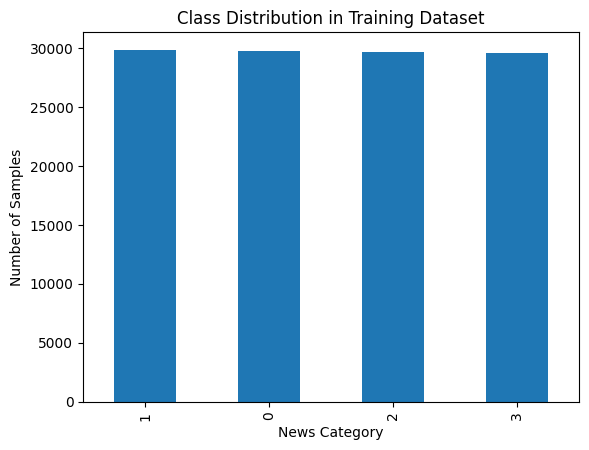

In [40]:


train_data_df['Label'].value_counts().plot(kind='bar')
plt.title('Class Distribution in Training Dataset')
plt.xlabel('News Category')
plt.ylabel('Number of Samples')
plt.show()


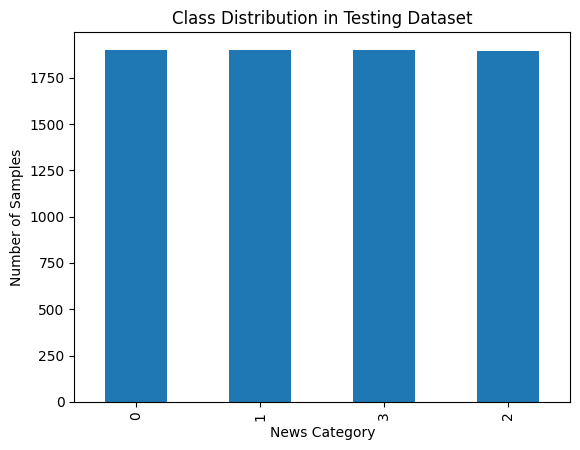

In [41]:
test_data_df['Label'].value_counts().plot(kind='bar')
plt.title('Class Distribution in Testing Dataset')
plt.xlabel('News Category')
plt.ylabel('Number of Samples')
plt.show()

**Word Cloud for each label**

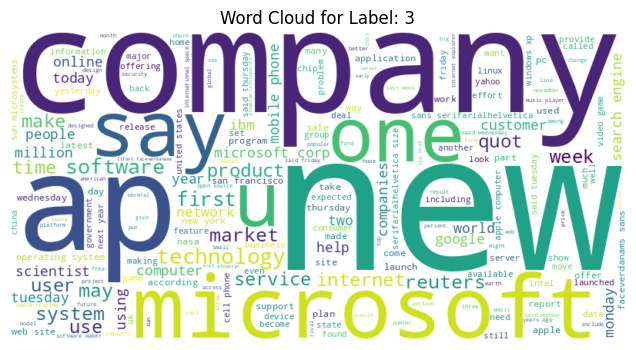

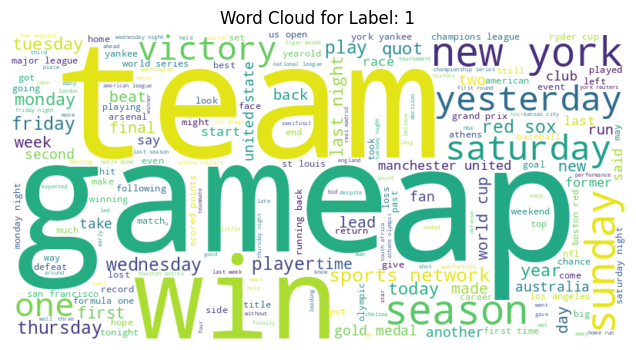

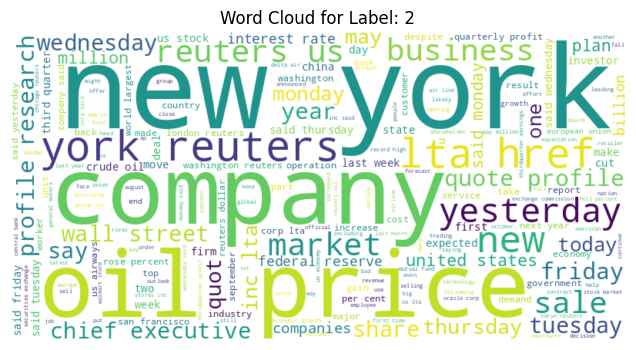

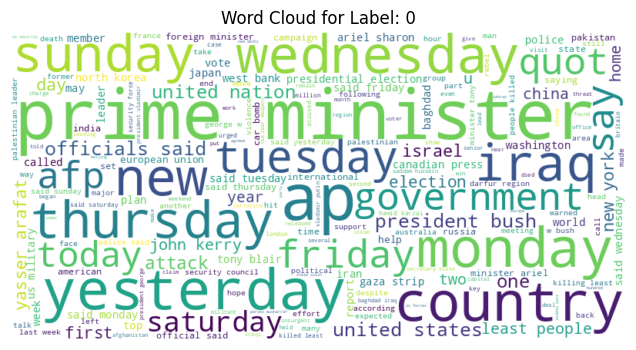

In [42]:

from wordcloud import WordCloud
# Plotting the word cloud
for label in train_data_df['Label'].unique():

    label_text = ' '.join(train_data_df[train_data_df['Label'] == label]['Text'])


    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(label_text)


    plt.figure(figsize=(8, 4))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Word Cloud for Label: {label}')
    plt.show()


**Bigram frequency for each label**

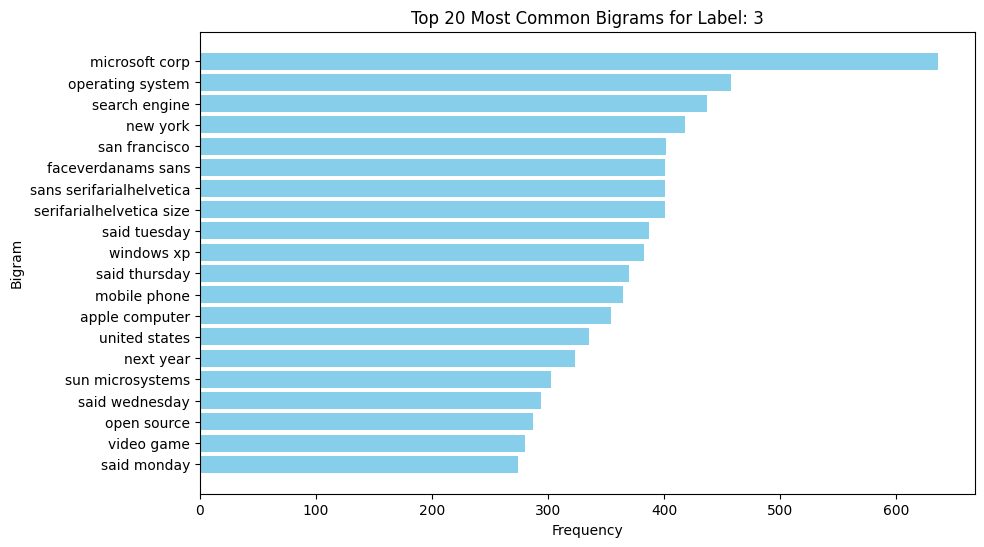

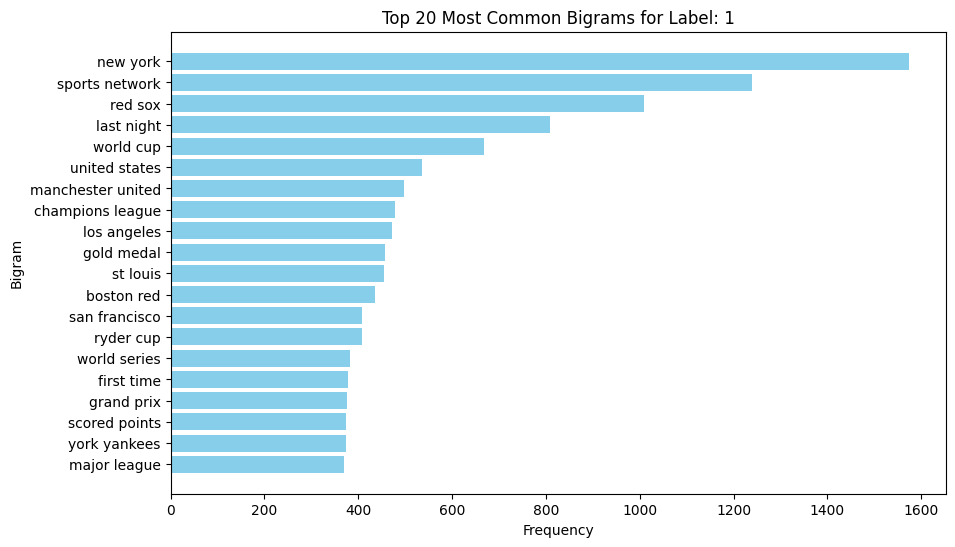

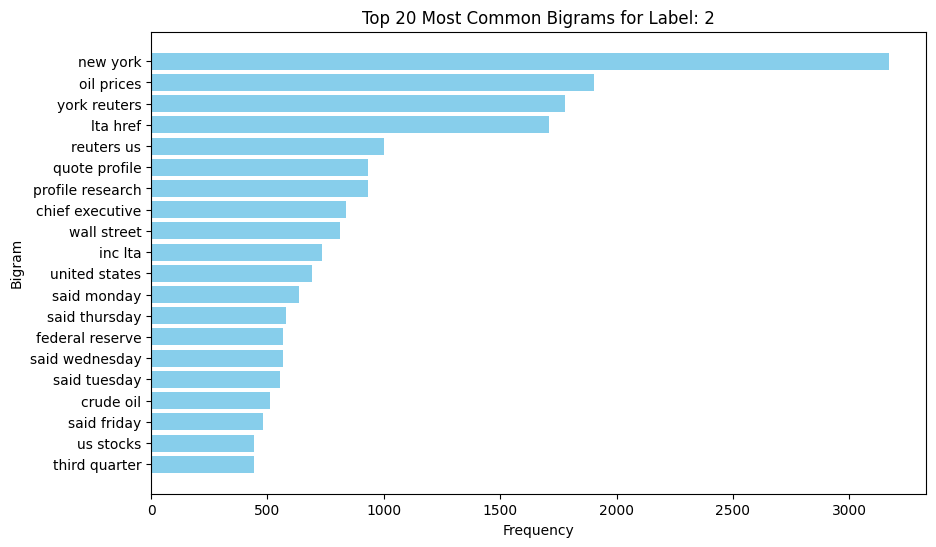

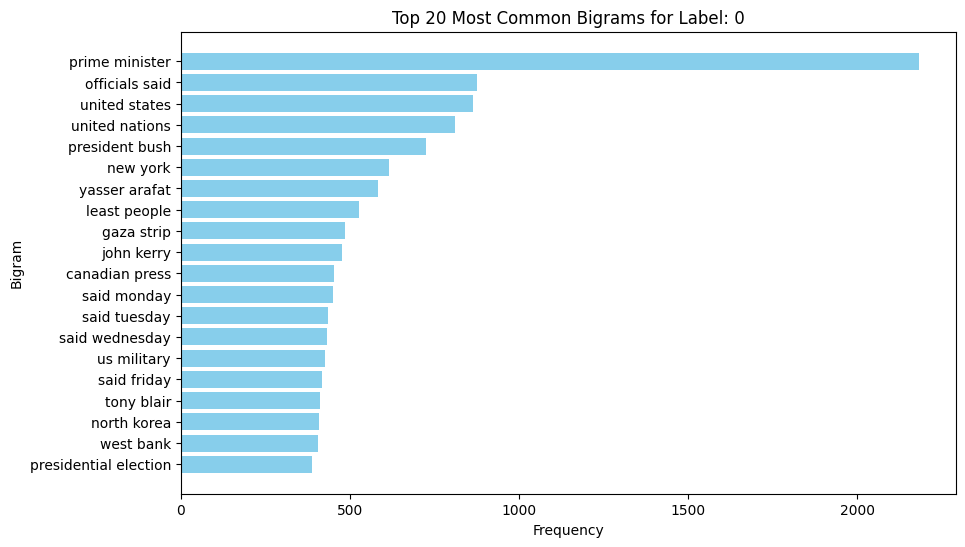

In [43]:
# Plotting the bigrams for the all label
def preprocess_text(text):
    stop_words = set(stopwords.words('english'))
    words = [word.lower() for word in text.split() if word.lower() not in stop_words]
    return words

train_data_df['Tokenized_Text'] = train_data_df['Text'].apply(preprocess_text)

def generate_bigrams(text):
    return list(ngrams(text, 2))

train_data_df['Bigrams'] = train_data_df['Tokenized_Text'].apply(generate_bigrams)
labels = train_data_df['Label'].unique()

for label in labels:

    label_data = train_data_df[train_data_df['Label'] == label]


    all_bigrams = [bigram for sublist in label_data['Bigrams'] for bigram in sublist]
    bigram_freq = Counter(all_bigrams)
    common_bigrams = bigram_freq.most_common(20)
    bigram_labels = [' '.join(bigram) for bigram, _ in common_bigrams]
    bigram_values = [count for _, count in common_bigrams]
    plt.figure(figsize=(10, 6))
    plt.barh(bigram_labels, bigram_values, color='skyblue')
    plt.xlabel('Frequency')
    plt.ylabel('Bigram')
    plt.title(f'Top 20 Most Common Bigrams for Label: {label}')
    plt.gca().invert_yaxis()
    plt.show()


**Tokenizing the pre-tokenized text and Padding**

In [44]:
#preprocessing data to fit the model
tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts(train_data_df['Text'])


X_train = tokenizer.texts_to_sequences(train_data_df['Text'])
X_test = tokenizer.texts_to_sequences(test_data_df['Text'])


max_sequence_length = 100
X_train = pad_sequences(X_train, maxlen=max_sequence_length)
X_test = pad_sequences(X_test, maxlen=max_sequence_length)


y_train = train_data_df['Label'].values
y_test = test_data_df['Label'].values


print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

X_train shape: (118828, 100)
X_test shape: (7594, 100)
y_train shape: (118828,)
y_test shape: (7594,)


In [45]:
model = tf.keras.Sequential([

    tf.keras.layers.Dense(4, activation='softmax')
])


In [46]:
vocab_size = len(tokenizer.word_index) + 1
print(f"Vocab size: {vocab_size}")
embedding_dim = 32  # No of embedding dimensions
max_sequence_length = 100  # Max length of input sequences
lstm_units = 64  # No of LSTM units



Vocab size: 83865


In [47]:


# Saving variables
with open('params.json', 'w') as f:
    json.dump({'vocab_size': vocab_size, 'embedding_dim': embedding_dim, 'max_sequence_length': max_sequence_length, 'lstm_units': lstm_units}, f)

# Loading variables
with open('params.json', 'r') as f:
    params = json.load(f)
vocab_size = params['vocab_size']
embedding_dim = params['embedding_dim']
max_sequence_length = params['max_sequence_length']
lstm_units = params['lstm_units']


**Define and Compile the LSTM Model**

In [48]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
label_encoder.fit(y_train)


LabelEncoder()

In [49]:

model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_sequence_length),
    LSTM(lstm_units, dropout=0.2, recurrent_dropout=0.2),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(len(label_encoder.classes_), activation='softmax')
])

# Compiling the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.build(input_shape=(None, max_sequence_length))
model.summary()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ (None, 100, 32)             │       2,683,680 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 64)                  │          24,832 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 4)                   │             260 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,712,932 (10.35 MB)

 Trainable params: 2,712,932 (10.35 MB)

 Non-trainable params: 0 (0.00 B)

**Train the LSTM Model**

In [50]:
# Defining callbacks
callbacks = [
    EarlyStopping(monitor='val_accuracy', patience=4, verbose=1, min_delta=1e-4),
    ModelCheckpoint(filepath='weights.keras', monitor='val_accuracy', mode='max', save_best_only=True, verbose=1)
]

# Training the model
history = model.fit(X_train, y_train,
                    batch_size=256,
                    validation_data=(X_test, y_test),
                    epochs=20,
                    callbacks=callbacks)

Epoch 1/20
465/465 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step - accuracy: 0.7004 - loss: 0.7661
Epoch 1: val_accuracy improved from -inf to 0.89795, saving model to weights.keras
465/465 ━━━━━━━━━━━━━━━━━━━━ 94s 186ms/step - accuracy: 0.7007 - loss: 0.7656 - val_accuracy: 0.8979 - val_loss: 0.3146
Epoch 2/20
465/465 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - accuracy: 0.9089 - loss: 0.2915
Epoch 2: val_accuracy improved from 0.89795 to 0.90190, saving model to weights.keras
465/465 ━━━━━━━━━━━━━━━━━━━━ 135s 180ms/step - accuracy: 0.9089 - loss: 0.2915 - val_accuracy: 0.9019 - val_loss: 0.2958
Epoch 3/20
465/465 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step - accuracy: 0.9202 - loss: 0.2535
Epoch 3: val_accuracy did not improve from 0.90190
465/465 ━━━━━━━━━━━━━━━━━━━━ 144s 185ms/step - accuracy: 0.9202 - loss: 0.2535 - val_accuracy: 0.8966 - val_loss: 0.3043
Epoch 4/20
465/465 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step - accuracy: 0.9269 - loss: 0.2276
Epoch 4: val_accuracy did not improve from 0.90190
465/465 ━━━━━━━

In [51]:
loss, accuracy = model.evaluate(X_test, y_test, verbose=1)
print(f"Test Accuracy: {accuracy * 100:.2f}%")


238/238 ━━━━━━━━━━━━━━━━━━━━ 11s 47ms/step - accuracy: 0.9020 - loss: 0.3165
Test Accuracy: 89.53%


**Evaluation Metrics**

238/238 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step


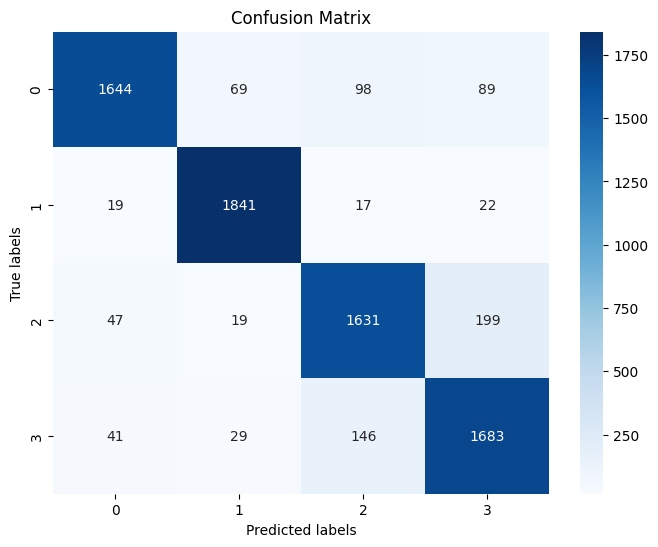

Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.87      0.90      1900
           1       0.94      0.97      0.95      1899
           2       0.86      0.86      0.86      1896
           3       0.84      0.89      0.86      1899

    accuracy                           0.90      7594
   macro avg       0.90      0.90      0.90      7594
weighted avg       0.90      0.90      0.90      7594

Accuracy: 0.90
Precision: 0.90
Recall: 0.90


In [52]:
#classification report and metrics
predictions = model.predict(X_test)
y_pred = np.argmax(predictions, axis=1)


plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

# Classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))


print(f"Accuracy: {accuracy_score(y_test, y_pred):.2f}")
print(f"Precision: {precision_score(y_test, y_pred, average='micro'):.2f}")
print(f"Recall: {recall_score(y_test, y_pred, average='micro'):.2f}")


238/238 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step


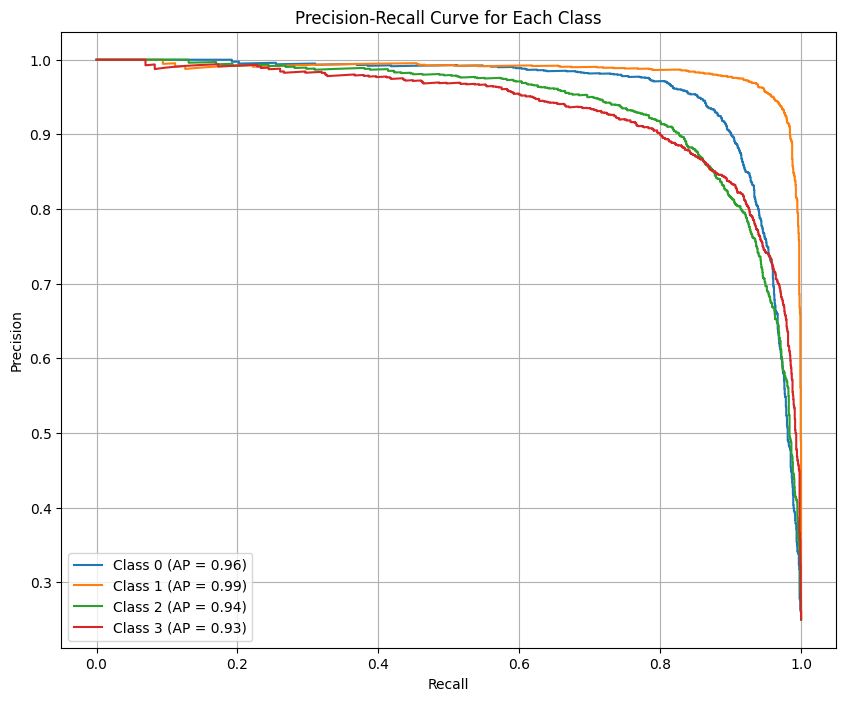

In [53]:



# Plotting the Precision-Recall curve
y_pred_proba = model.predict(X_test)

n_classes = y_pred_proba.shape[1]

precision = {}
recall = {}
average_precision = {}

for i in range(n_classes):
    precision[i], recall[i], _ = precision_recall_curve(
        (y_test == i).astype(int), y_pred_proba[:, i]
    )
    average_precision[i] = average_precision_score(
        (y_test == i).astype(int), y_pred_proba[:, i]
    )

plt.figure(figsize=(10, 8))
for i in range(n_classes):
    plt.plot(
        recall[i], precision[i], label=f"Class {i} (AP = {average_precision[i]:.2f})"
    )

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve for Each Class")
plt.legend(loc="lower left")
plt.grid()
plt.show()


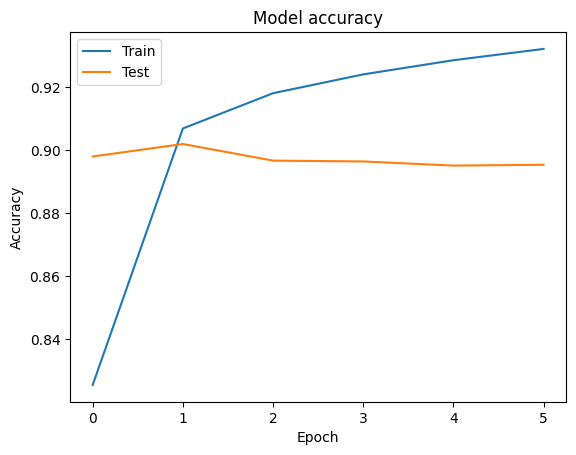

In [54]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

**CNN**

In [55]:
# Ensuring all entries are strings
train_data_df['Text'] = train_data_df['Text'].astype(str)
test_data_df['Text'] = test_data_df['Text'].astype(str)

In [56]:
# Parameters
MAX_NUM_WORDS = 20000  # Maximum number of words in the vocabulary
MAX_SEQUENCE_LENGTH = 128  # Maximum length of input sequences
EMBEDDING_DIM = 100  # Dimensionality of word embeddings

# Tokenizer
tokenizer = Tokenizer(num_words=MAX_NUM_WORDS)
tokenizer.fit_on_texts(train_data_df['Text'])
word_index = tokenizer.word_index

# Convert text to sequences
X_train = tokenizer.texts_to_sequences(train_data_df['Text'])
X_test = tokenizer.texts_to_sequences(test_data_df['Text'])

# Pad sequences
X_train = pad_sequences(X_train, maxlen=MAX_SEQUENCE_LENGTH)
X_test = pad_sequences(X_test, maxlen=MAX_SEQUENCE_LENGTH)

# Labels
y_train = tf.keras.utils.to_categorical(train_data_df['Label'], num_classes=4)
y_test = tf.keras.utils.to_categorical(test_data_df['Label'], num_classes=4)

In [57]:
# Input Layer
inputs = Input(shape=(MAX_SEQUENCE_LENGTH,))

# Embedding Layer
embedding_layer = Embedding(input_dim=MAX_NUM_WORDS,
                             output_dim=EMBEDDING_DIM,
                             input_length=MAX_SEQUENCE_LENGTH)(inputs)

# Convolutional Layers
conv1 = Conv1D(filters=128, kernel_size=3, activation='relu')(embedding_layer)
pool1 = GlobalMaxPooling1D()(conv1)

# Fully Connected Layers
dense1 = Dense(128, activation='relu')(pool1)
dropout = Dropout(0.5)(dense1)
outputs = Dense(4, activation='softmax')(dropout)

# Model
model = Model(inputs=inputs, outputs=outputs)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


**Compiling the model**

In [58]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])



**Training the model**

In [59]:
history = model.fit(X_train, y_train,
                    validation_data=(X_test, y_test),
                    epochs=10,
                    batch_size=256,
                    verbose=1)

Epoch 1/10
465/465 ━━━━━━━━━━━━━━━━━━━━ 12s 15ms/step - accuracy: 0.4104 - loss: 1.3292 - val_accuracy: 0.8459 - val_loss: 0.5898
Epoch 2/10
465/465 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.8553 - loss: 0.4903 - val_accuracy: 0.8861 - val_loss: 0.3456
Epoch 3/10
465/465 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.8998 - loss: 0.3200 - val_accuracy: 0.9014 - val_loss: 0.3051
Epoch 4/10
465/465 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.9177 - loss: 0.2626 - val_accuracy: 0.9066 - val_loss: 0.2861
Epoch 5/10
465/465 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.9297 - loss: 0.2246 - val_accuracy: 0.9089 - val_loss: 0.2775
Epoch 6/10
465/465 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.9386 - loss: 0.1966 - val_accuracy: 0.9099 - val_loss: 0.2747
Epoch 7/10
465/465 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.9452 - loss: 0.1758 - val_accuracy: 0.9107 - val_loss: 0.2753
Epoch 8/10
465/465 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.9536 - loss: 0.1512 - val_accuracy: 

In [60]:
loss, accuracy = model.evaluate(X_test, y_test, verbose=1)
print(f"Test Accuracy: {accuracy * 100:.2f}%")


238/238 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9069 - loss: 0.2944
Test Accuracy: 90.81%


***Evaluation Metrics***

238/238 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


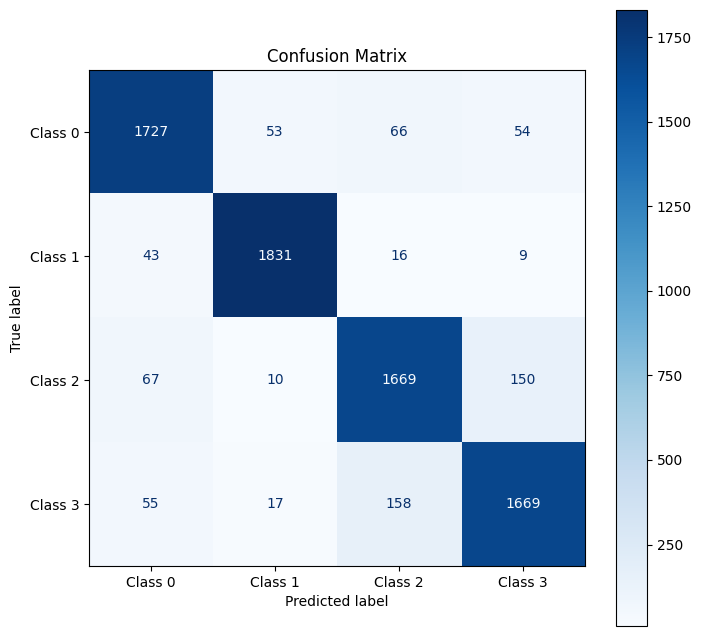

In [61]:

#plotting confusion matrix
y_pred = model.predict(X_test, verbose=1)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)
cm = confusion_matrix(y_true_classes, y_pred_classes)
labels = ['Class 0', 'Class 1', 'Class 2', 'Class 3']
plt.figure(figsize=(8, 8))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap='Blues', values_format='d', ax=plt.gca())
plt.title('Confusion Matrix')
plt.show()


In [62]:
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score, accuracy_score
#PRINTING METRICS AND CLASSIFICATION REPORT

precision = precision_score(y_true_classes, y_pred_classes, average='weighted')
recall = recall_score(y_true_classes, y_pred_classes, average='weighted')
f1 = f1_score(y_true_classes, y_pred_classes, average='weighted')
accuracy = accuracy_score(y_true_classes, y_pred_classes)


print("Classification Metrics:")
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision (Weighted): {precision:.2f}")
print(f"Recall (Weighted): {recall:.2f}")
print(f"F1-Score (Weighted): {f1:.2f}")

print("\nDetailed Classification Report:")
print(classification_report(y_true_classes, y_pred_classes, target_names=labels))

Classification Metrics:
Accuracy: 0.91
Precision (Weighted): 0.91
Recall (Weighted): 0.91
F1-Score (Weighted): 0.91

Detailed Classification Report:
              precision    recall  f1-score   support

     Class 0       0.91      0.91      0.91      1900
     Class 1       0.96      0.96      0.96      1899
     Class 2       0.87      0.88      0.88      1896
     Class 3       0.89      0.88      0.88      1899

    accuracy                           0.91      7594
   macro avg       0.91      0.91      0.91      7594
weighted avg       0.91      0.91      0.91      7594



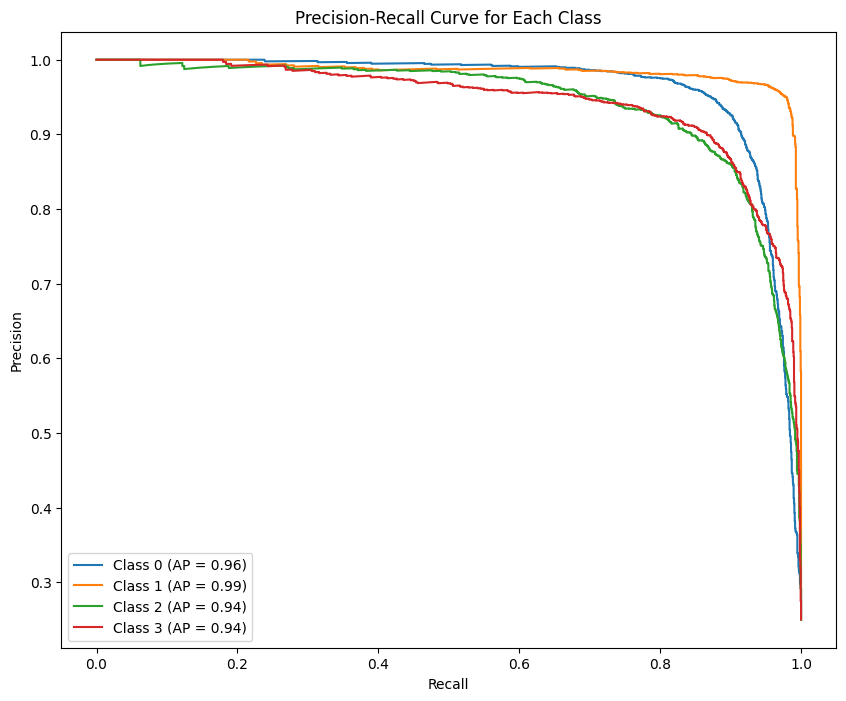

In [63]:


#plotting precision recall curve
precision = dict()
recall = dict()
average_precision = dict()
for i in range(4):
    precision[i], recall[i], _ = precision_recall_curve(y_test[:, i],
                                                        y_pred[:, i])
    average_precision[i] = average_precision_score(y_test[:, i], y_pred[:, i])


plt.figure(figsize=(10, 8))
for i in range(4):
    plt.plot(recall[i], precision[i], label=f'Class {i} (AP = {average_precision[i]:.2f})')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve for Each Class')
plt.legend(loc="lower left")
plt.show()

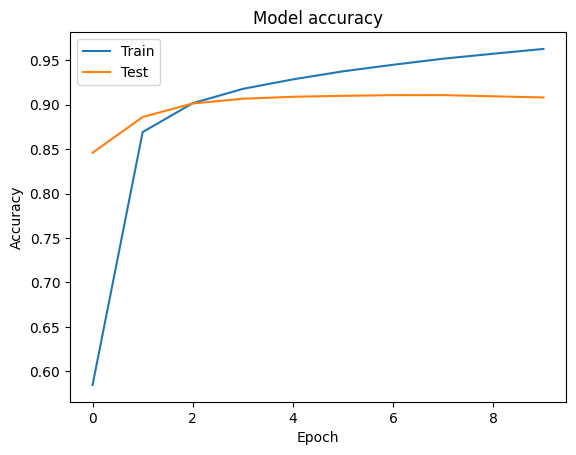

In [64]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [1]:
from google.colab import files

# Get the content of the current notebook
notebook_content = ''
with open('/content/AGNews_Classification_Final_Project (1).ipynb', 'r') as f:  # Replace with actual file name
  notebook_content = f.read()

# Save the content to a text file
with open('colab_notebook.txt', 'w') as f:
  f.write(notebook_content)

# Download the text file (optional)
files.download('colab_notebook.txt')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>